<a href="https://colab.research.google.com/github/code440/practice2/blob/master/bank_marketing_beginner_custum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/workspace/bank_data_mining_beginner
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/workspace/bank_data_mining_beginner
 202008130738			        result.csv
 202008130742			        signate.ipynb
 202008130816			        submit_202008130819.csv
 202008130819			        submit_202008131858.csv
 bank_marketing_beginner2.ipynb         submit_202008132212.csv
 bank_marketing_beginner_analys.ipynb   submit_202008132239.csv
 bank_marketing_beginner_custum.ipynb   submit_202008141019.csv
 bank_marketing_beginner.ipynb	        subm

In [2]:
import pandas as pd
import lightgbm as lgb
import warnings
import gc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import KFold
import os
import datetime
import pickle
import numpy as np
from sklearn.metrics import accuracy_score

warnings.simplefilter('ignore')

# 前処理

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submit_df = pd.read_csv('submit_sample.csv',header=None)

# 訓練データ、テストデータがわかるようにダミーの目的変数を代入
test_df['y']=-999

# 訓練データ、テストデータを結合
all_df = pd.concat([train_df,test_df])
# del train_df,test_df
# gc.collect()

# categorical_features = ['job', 'marital', 'education','default','housing','loan','contact','month','poutcome']
categorical_features = ['job', 'marital', 'education','default','housing','loan','contact','poutcome']

for col in categorical_features:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(all_df[col])
    lbl.transform(all_df[col])
    all_df[col]=lbl.transform(all_df[col])

name_peak_month = 'oct'
name_peak_second_month = 'mar'
# name_weak_month = 'may'

all_df = all_df.assign(peak_month=0)
all_df = all_df.assign(peak_second_month=0)

all_df['peak_month'] = np.where(all_df['month'] == name_peak_month, 1, 0)
all_df['peak_second_month'] = np.where(all_df['month'] == name_peak_second_month, 1, 0)

# tuning month
list_month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov']
dict_month = {}
for num, month in zip(range(1,12), list_month):
    dict_month[month] = num
all_df = all_df.replace(dict_month)

# age

# balance
balace = all_df['balance'].values
_balance_log1p = np.log1p(balace)
all_df = all_df.assign(balance_log1p=0)
all_df['balance_log1p'] = _balance_log1p

# pdays
_pdays_log1p = np.log1p(all_df['pdays'].values)
all_df = all_df.assign(pdays_log1p=0)
all_df['pdays_log1p'] = _pdays_log1p

# duration
_duration_log1p = np.log1p(all_df['duration'].values)
all_df = all_df.assign(duration_log1p=0)
all_df['duration_log1p'] = _duration_log1p

# RankGause
# all_df[all_df['y']!=-999]['duration']
from sklearn.preprocessing import QuantileTransformer
transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')

_values = all_df[all_df['y']!=-999]['duration'].values
_data = _values.reshape((len(_values),1))
transformer.fit(_data)

_values = all_df['duration'].values
_data_target = _values.reshape((len(_values),1))

_duration_rankgaus = transformer.transform(_data_target)
all_df = all_df.assign(duration_rankgaus=0)
all_df['duration_rankgaus'] = _duration_rankgaus

categorical_features += ['month']
categorical_features += ['peak_month']
categorical_features += ['peak_second_month']

print(categorical_features)

del train_df,test_df
gc.collect()

all_df

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month', 'peak_month', 'peak_second_month']


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,peak_month,peak_second_month,balance_log1p,pdays_log1p,duration_log1p,duration_rankgaus
0,0,31,7,1,1,0,12294,1,0,0,21,11,101,3,498,0,1,0,0,0,9.416948,6.212606,4.624973,-0.908458
1,1,29,2,2,2,0,43027,0,0,0,22,8,158,2,702,0,3,1,0,0,10.669606,6.555357,5.068904,-0.012660
2,2,35,4,1,2,0,12252,1,0,0,11,11,351,1,826,0,0,0,0,0,9.413526,6.717805,5.863631,1.399657
3,3,31,9,1,1,0,99121,1,1,2,16,5,658,2,120,0,0,0,0,0,11.504107,4.795791,6.490724,1.593219
4,4,48,10,1,0,0,42005,1,0,1,3,4,177,1,273,0,3,0,0,0,10.645568,5.613128,5.181784,0.321971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,18045,49,6,1,2,0,98357,1,0,0,6,7,101,2,417,0,0,-999,0,0,11.496369,6.035481,4.624973,-0.908458
18046,18046,34,1,1,1,0,29621,1,0,0,12,5,345,1,815,0,3,-999,0,0,10.296273,6.704414,5.846439,0.947401
18047,18047,34,0,2,1,0,94260,1,0,2,16,5,121,2,370,0,3,-999,0,0,11.453823,5.916202,4.804021,-0.619855
18048,18048,31,9,2,1,0,65483,1,0,2,15,5,345,2,41,0,3,-999,0,0,11.089561,3.737670,5.846439,0.947401


In [4]:
# 訓練データ、テストデータの分割
train_df = all_df[all_df['y']!=-999]
test_df = all_df[all_df['y']==-999]

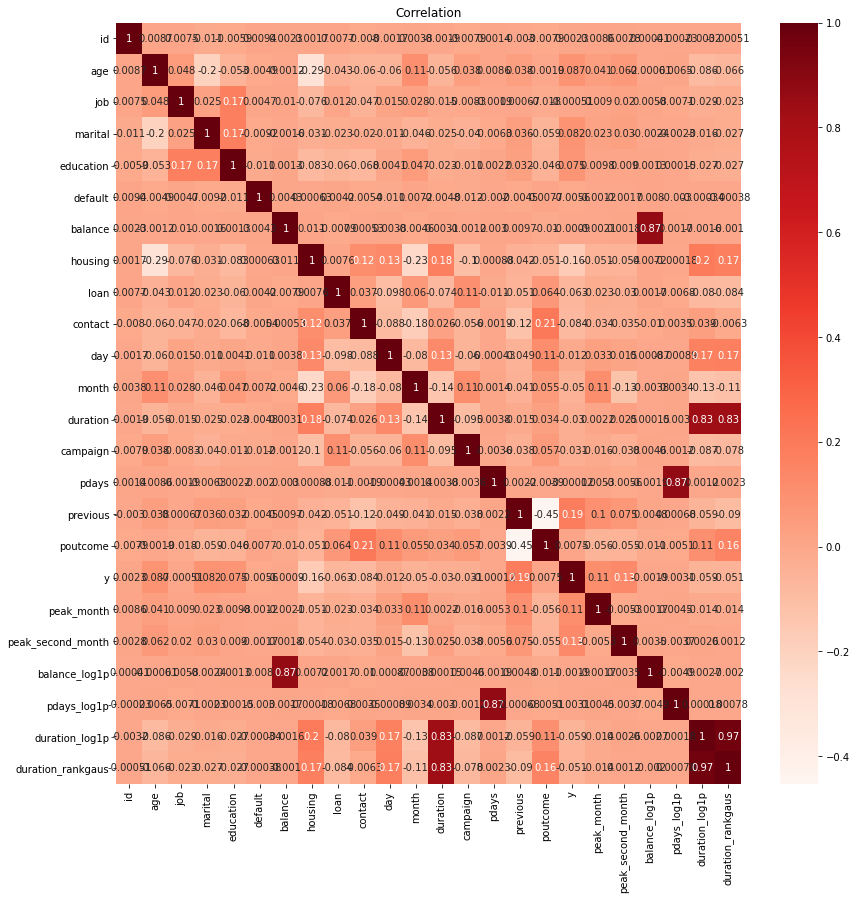

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = train_df.corr()

# heatmapを作成
# sns.heatmap(corr_matrix, cmap="Reds")
plt.figure(figsize=(14,14))
sns.heatmap(corr_matrix, cmap="Reds",annot=True)

plt.title('Correlation')
plt.show()

In [6]:
y_train = train_df['y']
X_train = train_df.drop(['y','id'], axis=1)
X_test = test_df.drop(['y','id'], axis=1)

In [7]:
# # 訓練データからデータを分割
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

# # 使用モデルはLGB（パラメータチューニング無）
# lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
# lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

# params = {
#     'objective': 'binary'
# }

# model = lgb.train(
#     params, lgb_train,
#     valid_sets=[lgb_train, lgb_eval],
#     verbose_eval=10,
#     num_boost_round=1000,
#     early_stopping_rounds=10
# )

# y_pred = model.predict(X_test, num_iteration=model.best_iteration)

In [8]:
# クロスバリデーション
# 訓練データからデータを分割
kf = KFold(n_splits=4, shuffle=True, random_state=71)

list_acc = []
list_pred_test = []

for train_idx, valid_idx in kf.split(X_train):
    x_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
    x_va, y_va = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    # 使用モデルはLGB（パラメータチューニング無）
    lgb_train = lgb.Dataset(x_tr, y_tr, categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(x_va, y_va, reference=lgb_train, categorical_feature=categorical_features)

    params = {
        'objective': 'binary'
    }

    model = lgb.train(
        params, lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        verbose_eval=10,
        num_boost_round=1000,
        early_stopping_rounds=10
    )

    _y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    list_pred_test.append(_y_pred)

    _y_val_pred = model.predict(x_va, num_iteration=model.best_iteration)
    y_val_pred = np.where(_y_val_pred > 0.5, 1, 0)
    _acc = accuracy_score(y_va, y_val_pred)
    list_acc.append(_acc)

# y_pred = np.mean(list_pred_test)

Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.21126	valid_1's binary_logloss: 0.213483
[20]	training's binary_logloss: 0.193075	valid_1's binary_logloss: 0.204035
[30]	training's binary_logloss: 0.181704	valid_1's binary_logloss: 0.200328
[40]	training's binary_logloss: 0.17256	valid_1's binary_logloss: 0.198216
[50]	training's binary_logloss: 0.165559	valid_1's binary_logloss: 0.197444
[60]	training's binary_logloss: 0.159068	valid_1's binary_logloss: 0.196936
[70]	training's binary_logloss: 0.153712	valid_1's binary_logloss: 0.196755
Early stopping, best iteration is:
[69]	training's binary_logloss: 0.154278	valid_1's binary_logloss: 0.196698
Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.208803	valid_1's binary_logloss: 0.219138
[20]	training's binary_logloss: 0.19057	valid_1's binary_logloss: 0.210767
[30]	training's binary_logloss: 0.178848	valid_1's binary_logloss: 0.207461
[40]	tra

In [9]:
print("list acc:", list_acc)
print("mean acc:", np.mean(list_acc))
y_pred = np.mean(list_pred_test)

list acc: [0.9332841328413284, 0.9326937269372694, 0.9298892988929889, 0.9297416974169742]
mean acc: 0.9314022140221402


In [13]:
list_pred_test

[array([0.83898283, 0.05074312, 0.02406745, ..., 0.148484  , 0.00526373,
        0.10379983]),
 array([0.74569531, 0.04882248, 0.02180877, ..., 0.08430777, 0.00820179,
        0.15525389]),
 array([0.804689  , 0.11875646, 0.03918491, ..., 0.0445644 , 0.01020672,
        0.14949074]),
 array([0.7417672 , 0.06538279, 0.02371449, ..., 0.05938573, 0.00728647,
        0.07690899])]

In [16]:
_y_pred = list_pred_test[0]
for pred in list_pred_test[1::]:
    _y_pred = np.vstack((_y_pred,pred))

y_pred = _y_pred.mean(axis=0)
y_pred

array([0.78278358, 0.07092621, 0.02719391, ..., 0.08418547, 0.00773968,
       0.12136336])

In [17]:
submit_df[1]=y_pred

In [18]:
# https://note.nkmk.me/python-datetime-pytz-timezone/
tz_jst = datetime.timezone(datetime.timedelta(hours=9), name='JST')
now = datetime.datetime.now(tz_jst)
time_now = '{0:%Y%m%d%H%M}'.format(now)
print(time_now) 

name_file = "submit_" + time_now + ".csv"
print("!signate submit --competition-id=292 ", name_file, " --note ")

submit_df.to_csv(name_file,index=False,header=None)

import pickle
# path2workspace
path2dir_out = "/content/drive/My Drive/workspace/bank_data_mining_beginner"
path2file_out = os.path.join(path2dir_out, "model_lgb_" + time_now + ".pkl")

with open(path2file_out, "wb") as f:
    pickle.dump(model, f)

202008151043
!signate submit --competition-id=292  submit_202008151043.csv  --note 


## 確率の補正
## adversarial validation